K‑means is a partitional clustering algorithm that groups data into *K* clusters by minimising the sum of squared distances between each point and its assigned cluster centroid.
- It is widely used for tasks such as market segmentation, image compression and EDA.

### Objective of K‑Means
K‑means partitions the data into *K* clusters by minimising the within‑cluster sum of squares:
$$J = \sum_{i=1}^N \sum_{j=1}^K r_{ij}\,\|x_i - \mu_j\|^2$$  

Now there:
- $x_i$ is the $i$-th data point.
- $\mu_j$ is the centroid of cluster $j$.
- $r_{ij}=1$ if $x_i$ is assigned to cluster $j$, else $0$. 

In [3]:
import random
import math
import matplotlib.pyplot as plt

random.seed(42)

#### Generate synthetic 2D blobs
We’re gonna place K centres on a circle and draw Gaussian points around each.

In [4]:
def generate_blobs(n_samples=300, centers=3, cluster_std=1.0, radius=5.0):
    blobs = []
    per_cluster = n_samples // centers
    for j in range(centers):
        angle = (2 * math.pi / centers) * j
        cx = radius * math.cos(angle)
        cy = radius * math.sin(angle)
        for _ in range(per_cluster):
            x = random.gauss(cx, cluster_std)
            y = random.gauss(cy, cluster_std)
            blobs.append((x, y))
    # If n_samples not exactly divisible, add remainder at first centre
    while len(blobs) < n_samples:
        x = random.gauss(radius, cluster_std)
        y = random.gauss(0, cluster_std)
        blobs.append((x, y))
    return blobs

X = generate_blobs()


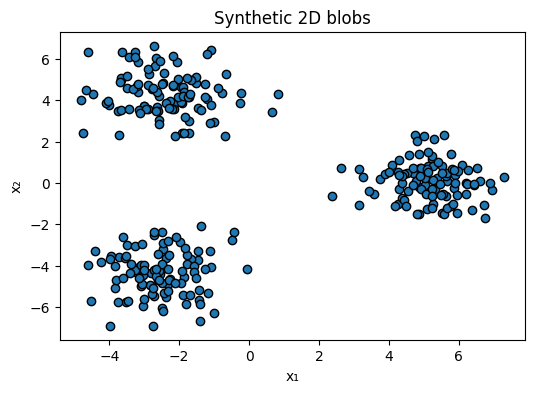

In [5]:
# Plot
xs, ys = zip(*X)
plt.figure(figsize=(6,4))
plt.scatter(xs, ys, edgecolors='k')
plt.title('Synthetic 2D blobs')
plt.xlabel('x₁'); plt.ylabel('x₂')
plt.show()

In [8]:
def euclidean(p, q):
    dx = p[0] - q[0]
    dy = p[1] - q[1]
    return math.hypot(dx, dy)

def all_distances(points, centroids):
    distances = []
    for point in points:
        distances_to_centroids = [euclidean(point, c) for c in centroids]
        distances.append(distances_to_centroids)
    return distances

### Now we are going to declare KMeans class

In [9]:
class KMeans:
    def __init__(self, K, max_iters=100, tol=1e-4, random_state=None):
        
        self.K = K
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state

    def _initialise_centroids(self, points):
        if self.random_state is not None:
            random.seed(self.random_state)
        return random.sample(points, self.K)

    def fit(self, points):
        centroids = self._initialise_centroids(points)

        for iteration in range(self.max_iters):
            distance_matrix = all_distances(points, centroids)
            labels = [distances.index(min(distances)) for distances in distance_matrix]

            new_centroids = []
            total_shift = 0.0

            for cluster_idx in range(self.K):
                members = [p for p, label in zip(points, labels) if label == cluster_idx]

                if members:
                    mean_x = sum(p[0] for p in members) / len(members)
                    mean_y = sum(p[1] for p in members) / len(members)
                    new_centroid = (mean_x, mean_y)
                else:
                    new_centroid = centroids[cluster_idx]

                total_shift += euclidean(centroids[cluster_idx], new_centroid)
                new_centroids.append(new_centroid)

            centroids = new_centroids

            if total_shift < self.tol:
                break

        self.centroids = centroids
        self.labels_ = labels
        return self

    def predict(self, points):

        distance_matrix = all_distances(points, self.centroids)
        return [distances.index(min(distances)) for distances in distance_matrix]

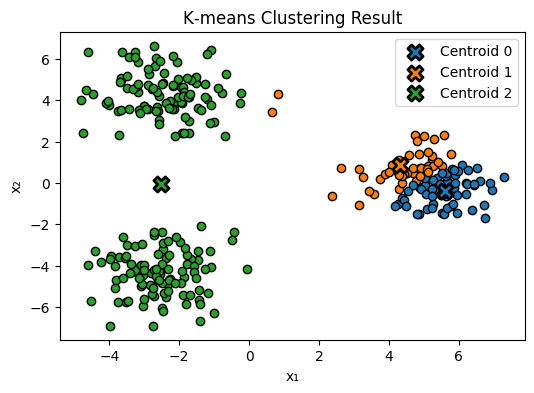

In [10]:
model = KMeans(K=3, random_state=42).fit(X)
labels = model.labels_
centroids = model.centroids

colors = ['tab:blue','tab:orange','tab:green','tab:red']
plt.figure(figsize=(6,4))
for idx, point in enumerate(X):
    c = colors[labels[idx] % len(colors)]
    plt.scatter(point[0], point[1], color=c, edgecolors='k')

for j, cent in enumerate(centroids):
    plt.scatter(cent[0], cent[1], 
                marker='X', s=120, edgecolors='k', linewidths=2, 
                label=f'Centroid {j}')
plt.title('K‑means Clustering Result')
plt.xlabel('x₁'); plt.ylabel('x₂')
plt.legend()
plt.show()

#### Elbow Method

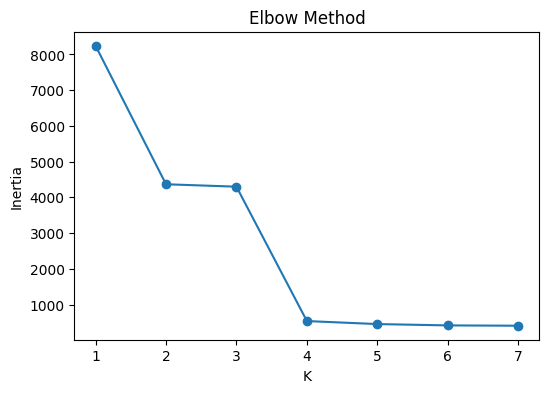

In [11]:
def inertia(points, centroids, labels):
    total = 0.0
    for i, p in enumerate(points):
        c = centroids[labels[i]]
        d = euclidean(p, c)
        total += d * d
    return total

Ks = list(range(1, 8))
inertias = []

for k in Ks:
    km = KMeans(K=k, random_state=42).fit(X)
    inertias.append(inertia(X, km.centroids, km.labels_))

plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker='o')
plt.title('Elbow Method'); plt.xlabel('K'); plt.ylabel('Inertia')
plt.xticks(Ks)
plt.show()

#### Silhouette Method

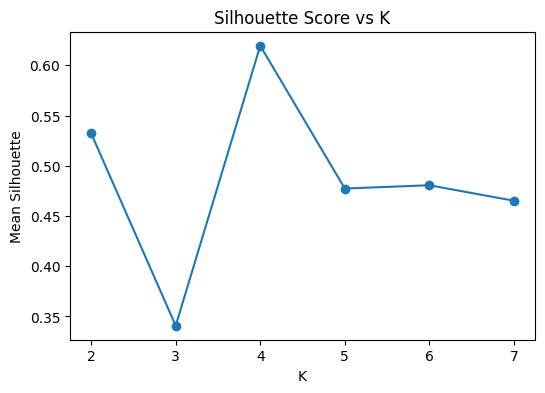

In [12]:
def silhouette(points, labels):
    n = len(points)
    dist = [[euclidean(points[i], points[j]) for j in range(n)] for i in range(n)]
    s_total = 0.0
    for i in range(n):
        own = labels[i]
        a_vals = [dist[i][j] for j in range(n) if labels[j] == own and j != i]
        a = sum(a_vals) / len(a_vals) if a_vals else 0.0
        b = float('inf')
        for k in set(labels):
            if k == own: continue
            k_vals = [dist[i][j] for j in range(n) if labels[j] == k]
            if k_vals:
                avg_k = sum(k_vals) / len(k_vals)
                if avg_k < b:
                    b = avg_k
        if b == float('inf'):
            s_i = 0.0
        else:
            s_i = (b - a) / max(a, b) if max(a, b) > 0 else 0.0
        s_total += s_i
    return s_total / n

# computing for K from 2 till 7)
Ks = list(range(2, 8))
silhs = []
for k in Ks:
    km = KMeans(K=k, random_state=42).fit(X)
    silhs.append(silhouette(X, km.labels_))

plt.figure(figsize=(6,4))
plt.plot(Ks, silhs, marker='o')
plt.title('Silhouette Score vs K')
plt.xlabel('K')
plt.ylabel('Mean Silhouette')
plt.xticks(Ks)
plt.show()

## What We've Understood from K‑Means, Elbow, and Silhouette Methods

### What is K‑Means?
K‑Means is a simple clustering algorithm that divides your data into K groups by finding K central points (centroids). It works by:
1. Randomly picking K centroids,
2. Assigning each point to the nearest centroid,
3. Updating the centroids to the average of their assigned points,
4. Repeating until the centroids stabilise.

It’s widely used due to its speed and simplicity—ideal for tasks like customer segmentation or pattern detection.

### What is the Elbow Method?
Choosing the right K is tricky.
The Elbow Method helps by plotting inertia (how compact clusters are) for various values of K. As K increases, inertia decreases, but after a point the improvement slows—this bend or “elbow” is the ideal K where adding more clusters yields diminishing returns.

### What is Silhouette Analysis?
Silhouette score measures how well each point fits into its assigned cluster compared to others. For each point:
- a(i) = average distance to points in the same cluster  
- b(i) = average distance to the nearest other cluster

The formula is like this:

$$s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$